In [53]:
#FLOOD RISK PREDICTION MODEL IN THE NAIROBI REGION
#-----------------------------------------------------

#CREATING A MACHINE LEARNING MODEL TO PREDICT FLOOD
#CREATING AN INTERACTIVE DASHBOARD TO INPUT FEATURES AND PREDICT FLOOD


In [54]:
#-------------------------------------------------------------
#1. DOWNLOADING RELEVANT LIBRARIES
#------------------------------------------------------------
!pip install earthengine-api geemap folium rasterio geopandas shapely scikit-learn xgboost matplotlib seaborn pandas numpy streamlit pyngrok




In [55]:
#---------------------------------------------------
#2.INITIALIZING EARTH ENGINE
#--------------------------------------------------
import ee, geemap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.base import clone
import joblib
import datetime
import warnings
import streamlit as st
from pyngrok import ngrok
import subprocess
ee.Authenticate()
ee.Initialize(project = 'nairobi-flooding-ml-model')



In [56]:
#-----------------------------------------------------------------
#3.LOADING AREA OF INTEREST (NAIROBI)
#---------------------------------------------------------------
nairobi_fc = ee.FeatureCollection("FAO/GAUL/2015/level2") \
                .filter(ee.Filter.eq('ADM2_NAME', 'Nairobi'))
aoi = nairobi_fc.geometry()
# Visualize AOI on map
Map = geemap.Map(center=[-1.286389, 36.817223], zoom=10)
Map.addLayer(nairobi_fc, {}, 'Nairobi AOI')
Map


Map(center=[-1.286389, 36.817223], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

In [57]:
# --------------------------------------------------------------
# 4. CREATING A SAMPLING GRID (POINTS INSIDE AOI)
# --------------------------------------------------------------
grid_spacing = 0.001  # roughly 100m between points

# Define bounding box of AOI
bounds = nairobi_fc.geometry().bounds()
coords = ee.List(bounds.coordinates().get(0))

# Extract longitude and latitude ranges
lons = coords.map(lambda xy: ee.List(xy).get(0))
lats = coords.map(lambda xy: ee.List(xy).get(1))

min_lon = ee.Number(lons.reduce(ee.Reducer.min()))
max_lon = ee.Number(lons.reduce(ee.Reducer.max()))
min_lat = ee.Number(lats.reduce(ee.Reducer.min()))
max_lat = ee.Number(lats.reduce(ee.Reducer.max()))

# Generate grid points
def create_points(lat):
    lat = ee.Number(lat)
    lon_seq = ee.List.sequence(min_lon, max_lon, grid_spacing)
    def create_point(lon):
        lon = ee.Number(lon)
        pt = ee.Geometry.Point([lon, lat])
        return ee.Feature(pt).set('lat', lat).set('lon', lon) if nairobi_fc.geometry().contains(pt) else None
    return lon_seq.map(create_point)

lat_seq = ee.List.sequence(min_lat, max_lat, grid_spacing)
grid_points_list = lat_seq.map(create_points).flatten()
grid_fc = ee.FeatureCollection(grid_points_list).filter(ee.Filter.notNull(['lat']))

print("✅ Grid created with", grid_fc.size().getInfo(), "points")

✅ Grid created with 125840 points


In [58]:
#-------------------------------------------------------
# 5.LOADING CHIRPS DAILY RAINFALL DATA
#----------------------------------------------------
chirps_daily = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
    .filterDate('2022-01-01', '2022-12-31') \
    .filterBounds(aoi) \
    .select('precipitation')

# 1️⃣ Maximum daily rainfall in the year
rain_max = chirps_daily.max().rename('rain_max').clip(aoi)

# 2️⃣ 7-day cumulative rainfall
rain_cum7 = chirps_daily.reduce(ee.Reducer.sum()).rename('rain_cum7').clip(aoi)

# 3️⃣ Heavy rain days (>20mm)
heavy_rain_days = chirps_daily.map(lambda img: img.gt(20).rename('heavy_rain')) \
    .sum() \
    .rename('heavy_rain_days') \
    .clip(aoi)

# 4️⃣ Extreme rain days (>50mm)
heavy_rain_50_days = chirps_daily.map(lambda img: img.gt(50).rename('extreme_rain')) \
    .sum() \
    .rename('heavy_rain_50_days') \
    .clip(aoi)

# 5️⃣ Rainfall intensity (average rainfall on rainy days >1mm)
rainy_days = chirps_daily.map(lambda img: img.gt(1).rename('rainy')).sum()
rain_intensity = rain_cum7.divide(rainy_days).rename('rain_intensity').clip(aoi)


In [59]:
# --------------------------------------------------------------
# 6.ADDITIONAL FEATURES
# --------------------------------------------------------------



# 2️⃣ Elevation (SRTM)
elev = ee.Image("USGS/SRTMGL1_003").clip(aoi).rename('elevation')

# 3️⃣ Slope (from elevation)
slope = ee.Terrain.slope(elev).rename('slope').clip(aoi)

# 4️⃣ NDVI (vegetation index)
ndvi = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterDate('2022-01-01', '2022-12-31') \
    .filterBounds(aoi) \
    .map(lambda img: img.normalizedDifference(['B8', 'B4']).rename('ndvi')) \
    .mean()

# 5️⃣ NDBI (built-up index)
ndbi = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterDate('2022-01-01', '2022-12-31') \
    .filterBounds(aoi) \
    .map(lambda img: img.normalizedDifference(['B11', 'B8']).rename('ndbi')) \
    .mean()




In [60]:
# --------------------------------------------------------------
# 7.. LOAD GLOBAL SURFACE WATER TO CREATE FLOOD MODEL
# --------------------------------------------------------------
gsw = ee.Image("JRC/GSW1_4/GlobalSurfaceWater")

# Percentage of time water was detected
water_occurrence = gsw.select('occurrence').clip(aoi).rename('water_occurrence')

# Seasonality (months water present)
seasonality = gsw.select('seasonality').clip(aoi)

# Mask out permanent water
flood_prone_mask = seasonality.lt(6)

# Create flood label: 1 = flood-prone, 0 = not flood-prone
flood_label = water_occurrence.gt(20).updateMask(flood_prone_mask).rename('flood_label')

# Visualize labels
Map = geemap.Map(center=[-1.286389, 36.817223], zoom=10)
Map.addLayer(nairobi_fc, {}, 'Nairobi AOI')
Map.addLayer(water_occurrence, {'min':0, 'max':100, 'palette':['white','blue']}, 'Water Occurrence (JRC)')
Map.addLayer(flood_label, {'min':0, 'max':1, 'palette':['white','red']}, 'Flood-Prone Areas (Label)')
Map

Map(center=[-1.286389, 36.817223], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

In [61]:
# --------------------------------------------------------------
# 8. COMBINE ALL PREDICTORS AND LABELS INTO ONE DATASET IMAGE
#--------------------------------------------------------------
dataset_img = ee.Image.cat([
    rain_max.rename('rain_max'),
    rain_cum7.rename('rain_cum7'),
    heavy_rain_days.rename('heavy_rain_days'),
    heavy_rain_50_days.rename('heavy_rain_50_days'),
    rain_intensity.rename('rain_intensity'),
    elev.rename('elevation'),
    slope.rename('slope'),
    ndvi.rename('ndvi'),
    ndbi.rename('ndbi'),
    flood_label.rename('flood_label')
]).clip(aoi)


In [62]:
#--------------------------------------------------------------
#9. SAMPLE DATA SETS AT GRID POINTS
# --------------------------------------------------------------
training_data = dataset_img.sampleRegions(
    collection=grid_fc,
    properties=['lat', 'lon'],
    scale=30,
    geometries=True
)

print("✅ Sampling done successfully.")

✅ Sampling done successfully.


In [63]:
# --------------------------------------------------------------
# 10. CONVERT TO PANDAS DATAFRAME
# --------------------------------------------------------------
geojson_data = geemap.ee_to_geojson(training_data)
training_df = pd.json_normalize(geojson_data["features"])
training_df = training_df.rename(columns=lambda x: x.replace("properties.", ""))
training_df = training_df.drop(columns=['type', 'geometry.type', 'geometry.coordinates'], errors='ignore')



In [64]:
# --------------------------------------------------------------
# 11. CLEAN AND INSPECT DATA
# --------------------------------------------------------------

# Remove any rows with missing values
training_df = training_df.dropna()

# Define the expected columns including all rainfall features
expected_cols = [
    'lat', 'lon',
    'rain_max', 'rain_cum7', 'heavy_rain_days', 'heavy_rain_50_days', 'rain_intensity',
    'elevation', 'slope', 'ndvi', 'ndbi',
    'flood_label'
]

# Keep only the expected columns
training_df = training_df[[c for c in expected_cols if c in training_df.columns]]

# Summary
print(f"✅ Dataset ready — {training_df.shape[0]} samples, {training_df.shape[1]} features.")
display(training_df.head(10))


✅ Dataset ready — 122 samples, 12 features.


,lat,lon,rain_max,rain_cum7,heavy_rain_days,heavy_rain_50_days,rain_intensity,elevation,slope,ndvi,ndbi,flood_label
0,-1.410854,36.92906,44.588326,446.072233,3,0,10.373773,1515,6.721387,0.030249,-0.041563,0
1,-1.351854,36.88906,92.052704,549.744675,7,1,13.743617,1637,0.927410,0.029324,-0.023746,0
2,-1.347854,36.89906,40.372757,521.650653,4,0,10.228444,1637,1.311623,0.076049,0.047860,0
3,-1.343854,36.86906,40.372757,521.650653,4,0,10.228444,1622,8.238928,0.108808,-0.011513,0
4,-1.342854,36.88206,40.372757,521.650653,4,0,10.228444,1643,2.621869,-0.007414,-0.046905,0
5,-1.338854,36.81006,49.193584,608.700768,7,0,11.067287,1664,0.927663,0.060311,-0.184698,1
6,-1.336854,36.88606,40.372757,521.650653,4,0,10.228444,1635,4.627367,0.038584,0.068037,0
7,-1.328854,36.92606,45.744591,517.406367,4,0,10.779299,1617,2.781035,0.002326,-0.010534,0
8,-1.327854,36.84306,49.193584,608.700768,7,0,11.067287,1653,7.928309,0.046410,0.022583,0
9,-1.327854,36.84406,49.193584,608.700768,7,0,11.067287,1642,3.819443,0.112187,-0.009727,0


In [65]:
# --------------------------------------------------------------
# 12. EXPLORATORY DATA ANALYSIS
# --------------------------------------------------------------
#a.Data structure
training_df.info()
training_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   lat                 122 non-null    float64
 1   lon                 122 non-null    float64
 2   rain_max            122 non-null    float64
 3   rain_cum7           122 non-null    float64
 4   heavy_rain_days     122 non-null    int64  
 5   heavy_rain_50_days  122 non-null    int64  
 6   rain_intensity      122 non-null    float64
 7   elevation           122 non-null    int64  
 8   slope               122 non-null    float64
 9   ndvi                122 non-null    float64
 10  ndbi                122 non-null    float64
 11  flood_label         122 non-null    int64  
dtypes: float64(8), int64(4)
memory usage: 11.6 KB


,0
lat,0
lon,0
rain_max,0
rain_cum7,0
heavy_rain_days,0
heavy_rain_50_days,0
rain_intensity,0
elevation,0
slope,0
ndvi,0


In [66]:

# --------------------------------------------------------------
#b.Mean and distribution of data

training_df.describe()

,lat,lon,rain_max,rain_cum7,heavy_rain_days,heavy_rain_50_days,rain_intensity,elevation,slope,ndvi,ndbi,flood_label
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,-1.250542,36.976068,61.160760,491.349651,5.491803,1.040984,11.435213,1523.557377,2.043392,0.104619,-0.120349,0.459016
std,0.034088,0.077392,17.402637,50.442614,1.248112,0.594709,1.281040,82.910292,3.357654,0.052264,0.094260,0.500372
min,-1.410854,36.738060,40.372757,446.072233,3.000000,0.000000,10.228444,1481.000000,0.000000,-0.033299,-0.286018,0.000000
25%,-1.247854,36.972060,56.247597,465.819083,5.000000,1.000000,10.833002,1481.000000,0.000000,0.077407,-0.208210,0.000000
50%,-1.243854,37.014060,56.247597,465.819083,5.000000,1.000000,10.833002,1481.000000,0.000000,0.111889,-0.117455,0.000000
75%,-1.240854,37.020060,56.247597,465.819083,5.000000,1.000000,11.035338,1509.250000,3.238180,0.135212,-0.042120,1.000000
max,-1.169854,37.038060,119.160706,691.936320,9.000000,3.000000,15.898841,1855.000000,13.650192,0.254190,0.068037,1.000000


In [67]:

# --------------------------------------------------------------
# c. Comparing flood prone vs non-flood areas
training_df.groupby('flood_label').mean(numeric_only=True)


,lat,lon,rain_max,rain_cum7,heavy_rain_days,heavy_rain_50_days,rain_intensity,elevation,slope,ndvi,ndbi
flood_label,,,,,,,,,,,
0,-1.255535,36.980590,60.184433,488.875850,5.318182,1.015152,11.36222,1521.560606,2.018419,0.100890,-0.083145
1,-1.244657,36.970738,62.311431,494.265201,5.696429,1.071429,11.52124,1525.910714,2.072825,0.109015,-0.164196


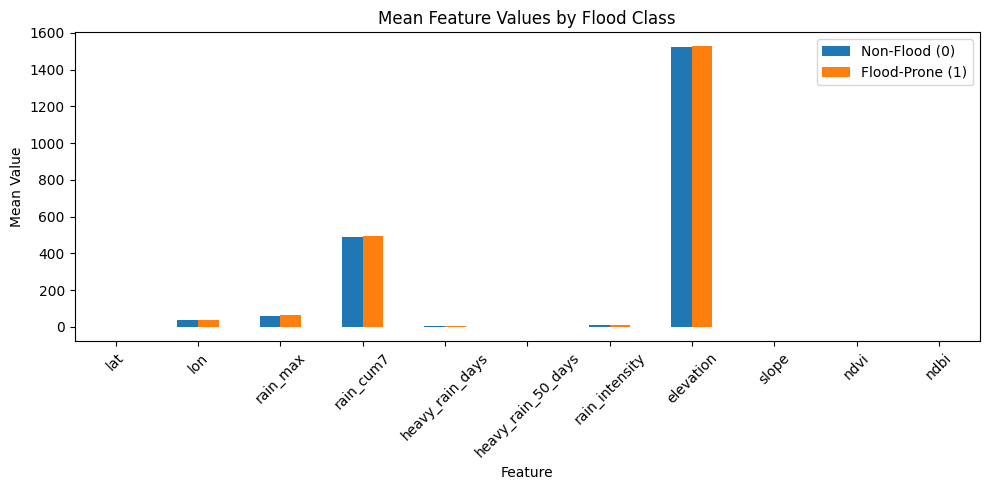

In [68]:

# --------------------------------------------------------------
#d.Comparing flooded and non-flooded samples

means = training_df.groupby('flood_label').mean(numeric_only=True).T

# Plot
means.plot(kind='bar', figsize=(10,5))
plt.title('Mean Feature Values by Flood Class')
plt.xlabel('Feature')
plt.ylabel('Mean Value')
plt.legend(['Non-Flood (0)', 'Flood-Prone (1)'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

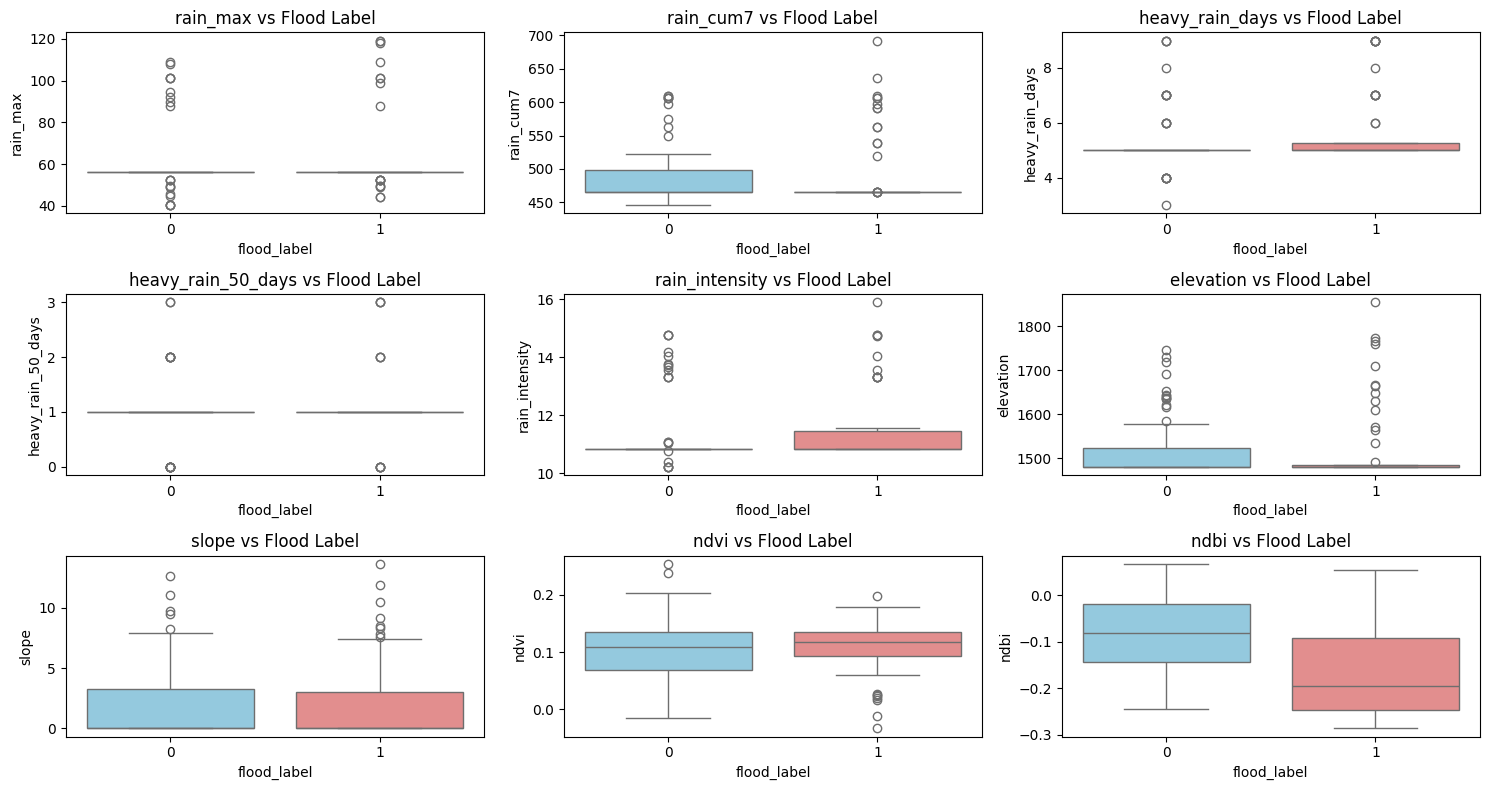

In [69]:

# --------------------------------------------------------------
#e. Boxplots

# Include all relevant features, including enhanced rainfall metrics
features = [
    'rain_max', 'rain_cum7', 'heavy_rain_days', 'heavy_rain_50_days', 'rain_intensity',
    'elevation', 'slope', 'ndvi', 'ndbi'
]

plt.figure(figsize=(15,8))
for i, col in enumerate(features, 1):
    plt.subplot(3, 3, i)  # adjust grid for 9 features
    sns.boxplot(x='flood_label', y=col, data=training_df, palette=['skyblue', 'lightcoral'])
    plt.title(f'{col} vs Flood Label')
plt.tight_layout()
plt.show()


In [70]:

# --------------------------------------------------------------
#g.Show strongly features are correlated to flooding- tabular formart

corr = training_df.corr()

# Extract correlation with flood_label and convert to DataFrame
flood_corr = (
    corr['flood_label']
    .drop('flood_label')
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'index': 'Feature', 'flood_label': 'Correlation'})
)

# Add absolute correlation column (for easy ranking by strength)
flood_corr['|Correlation|'] = flood_corr['Correlation'].abs()

# Sort by absolute correlation
flood_corr = flood_corr.sort_values(by='|Correlation|', ascending=False)

# Display table
print("📊 Feature Correlation with Flood Label:\n")
display(flood_corr)

📊 Feature Correlation with Flood Label:



,Feature,Correlation,|Correlation|
10,ndbi,-0.430249,0.430249
0,lat,0.159678,0.159678
1,heavy_rain_days,0.151640,0.151640
2,ndvi,0.077795,0.077795
9,lon,-0.063696,0.063696
3,rain_intensity,0.062113,0.062113
4,rain_max,0.061157,0.061157
5,rain_cum7,0.053460,0.053460
6,heavy_rain_50_days,0.047350,0.047350
7,elevation,0.026253,0.026253


In [71]:
# --------------------------------------------------------------
# 13. MODEL TRAINING — Updated Features
# --------------------------------------------------------------

# Define features and target (including all rainfall features)
features = [
    'rain_max', 'rain_cum7', 'heavy_rain_days', 'heavy_rain_50_days', 'rain_intensity',
    'elevation', 'slope', 'ndvi', 'ndbi'
]

X = training_df[features]
y = training_df['flood_label']

# Split into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("✅ Data split complete.")
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


✅ Data split complete.
Training samples: 85, Test samples: 37


In [72]:
#-------------------------------------------------------------
# 14. INITIALIZE RANDOM FOREST
#-------------------------------------------------------------
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    random_state=42,
    class_weight='balanced'
)

# Train
rf_model.fit(X_train, y_train)

# ✅ Save fitted model
joblib.dump(rf_model, "rf_flood_model.pkl")


['rf_flood_model.pkl']

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.90      0.80        20
           1       0.83      0.59      0.69        17

    accuracy                           0.76        37
   macro avg       0.78      0.74      0.74        37
weighted avg       0.77      0.76      0.75        37



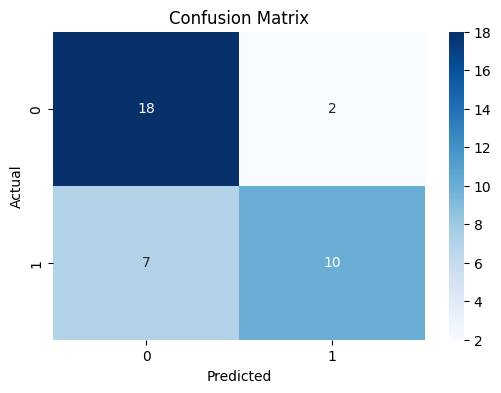

ROC-AUC Score: 0.735


In [73]:
# --------------------------------------------------------------
# 15. EVALUATION OF RANDOM FOREST MODEL
# --------------------------------------------------------------

# Predictions
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]


print("📄 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", round(roc_auc, 3))


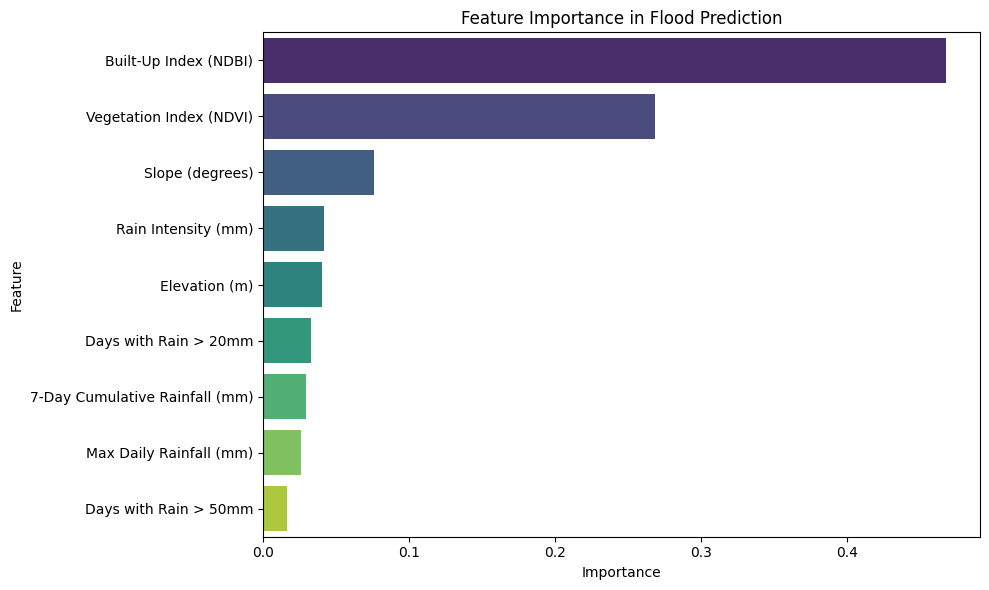

,Feature,Importance
8,Built-Up Index (NDBI),0.468045
7,Vegetation Index (NDVI),0.268540
6,Slope (degrees),0.076123
4,Rain Intensity (mm),0.042036
5,Elevation (m),0.040718
2,Days with Rain > 20mm,0.032916
1,7-Day Cumulative Rainfall (mm),0.029624
0,Max Daily Rainfall (mm),0.025816
3,Days with Rain > 50mm,0.016182


In [75]:
# --------------------------------------------------------------
# 16. FEATURE IMPORTANCE — Updated Features (Descriptive Names)
# --------------------------------------------------------------

# Short feature names
features = [
    'rain_max', 'rain_cum7', 'heavy_rain_days', 'heavy_rain_50_days', 'rain_intensity',
    'elevation', 'slope', 'ndvi', 'ndbi'
]

# Map to descriptive names
feature_names = {
    'rain_max': 'Max Daily Rainfall (mm)',
    'rain_cum7': '7-Day Cumulative Rainfall (mm)',
    'heavy_rain_days': 'Days with Rain > 20mm',
    'heavy_rain_50_days': 'Days with Rain > 50mm',
    'rain_intensity': 'Rain Intensity (mm)',
    'elevation': 'Elevation (m)',
    'slope': 'Slope (degrees)',
    'ndvi': 'Vegetation Index (NDVI)',
    'ndbi': 'Built-Up Index (NDBI)'
}

# Create importance DataFrame with descriptive names
importance = pd.DataFrame({
    'Feature': [feature_names[f] for f in features],
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance, palette='viridis')
plt.title("Feature Importance in Flood Prediction")
plt.tight_layout()
plt.show()

# Display numeric importance
importance


In [76]:
# --------------------------------------------------------------
# 17. SAFE CROSS VALIDATION
# --------------------------------------------------------------


# Features and target
X = training_df.drop(columns=['flood_label'])
y = training_df['flood_label']

# Use the SAME hyperparameters as your trained model
base_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    random_state=42,
    class_weight='balanced'
)

# Create a clone for cross-validation (does not overwrite main model)
cv_model = clone(base_model)

# Stratified 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validate using ROC-AUC (good for imbalanced data)
cv_scores = cross_val_score(cv_model, X, y, cv=skf, scoring='roc_auc')

print("Cross-Validation ROC-AUC Scores:", cv_scores)
print("Mean ROC-AUC:", np.mean(cv_scores).round(3))
print("Std Dev:", np.std(cv_scores).round(3))


Cross-Validation ROC-AUC Scores: [0.86363636 0.82051282 0.68531469 0.67132867 0.86013986]
Mean ROC-AUC: 0.78
Std Dev: 0.085


In [77]:

# --------------------------------------------------------------
# 18. LOAD MODEL
# --------------------------------------------------------------
rf_model = joblib.load("rf_flood_model.pkl")


In [78]:
# --------------------------------------------------------------
# 19. AUTHENTICATE NGROK
# --------------------------------------------------------------
ngrok.set_auth_token("35EiueW2XibuEVgoqm6vFMhimvg_4viToirDsu8EKY4XZTymq")


In [79]:
# --------------------------------------------------------------
# 20. WRITE STREAMLIT APP FILE
# --------------------------------------------------------------

%%writefile flood_dashboard.py
import streamlit as st
import pandas as pd
import joblib

# Load model
rf_model = joblib.load("rf_flood_model.pkl")

# Page configuration
st.set_page_config(
    page_title="Nairobi Flood Risk Predictor",
    page_icon="🌧️",
    layout="wide"
)

st.title("Nairobi Flood Risk Prediction Dashboard")
st.write("This tool predicts flood probability based on rainfall, terrain, vegetation, and urbanization features.")

# Sidebar inputs
st.sidebar.header("Input Environmental Features")

lat = st.sidebar.number_input("Latitude", value=-1.286389, format="%.6f")
lon = st.sidebar.number_input("Longitude", value=36.817223, format="%.6f")

st.sidebar.subheader("Rainfall Features")
rain_max = st.sidebar.number_input("Max daily rainfall (mm)", value=40.0)
rain_cum7 = st.sidebar.number_input("7-day cumulative rainfall (mm)", value=300.0)
heavy_rain_days = st.sidebar.number_input("Days >20mm rainfall", value=3)
heavy_rain_50_days = st.sidebar.number_input("Days >50mm rainfall", value=1)
rain_intensity = st.sidebar.number_input("Rain intensity (mm)", value=25.0)

st.sidebar.subheader("Terrain & Vegetation")
elevation = st.sidebar.number_input("Elevation (m)", value=1600)
slope = st.sidebar.number_input("Slope (degrees)", value=5.0)
ndvi = st.sidebar.number_input("NDVI", value=0.1)
ndbi = st.sidebar.number_input("NDBI", value=0.05)

# Prediction
if st.sidebar.button("Predict Flood Risk"):

    data = pd.DataFrame([[rain_max, rain_cum7, heavy_rain_days,
                          heavy_rain_50_days, rain_intensity,
                          elevation, slope, ndvi, ndbi]],
                         columns=["rain_max", "rain_cum7", "heavy_rain_days",
                                  "heavy_rain_50_days", "rain_intensity",
                                  "elevation", "slope", "ndvi", "ndbi"])

    prob = rf_model.predict_proba(data)[0][1]
    label = rf_model.predict(data)[0]

    st.subheader("Flood Prediction Results")

    if prob < 0.3:
        risk_color, risk_label = "green", "LOW RISK"
    elif prob < 0.6:
        risk_color, risk_label = "orange", "MEDIUM RISK"
    else:
        risk_color, risk_label = "red", "HIGH RISK"

    st.markdown(f"""
        <div style="padding:20px; border-radius:10px; background-color:{risk_color}; color:white">
            <h2>Flood Risk: {risk_label}</h2>
            <h3>Probability: {prob*100:.2f}%</h3>
            <h4>Binary Prediction: {"Flood-Prone (1)" if label==1 else "Not Flood-Prone (0)"} </h4>
        </div>
    """, unsafe_allow_html=True)

    st.subheader("Location on Map")
    st.map(pd.DataFrame({'lat':[lat], 'lon':[lon]}))

    st.subheader("Input Summary")
    st.dataframe(data.T.rename(columns={0: "Value"}))


Overwriting flood_dashboard.py


In [80]:
# --------------------------------------------------------------
# 21. RUN STREAMLIT DASHBOARD
# --------------------------------------------------------------

# Set up ngrok tunnel to port 8501
public_url = ngrok.connect(8501)
print("Your Streamlit app will be available at:", public_url)

# Run the Streamlit app in the background
proc = subprocess.Popen(
    ["streamlit", "run", "flood_dashboard.py",
     "--server.port=8501", "--server.address=0.0.0.0"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)


Your Streamlit app will be available at: NgrokTunnel: "https://melaine-unreclined-catarina.ngrok-free.dev" -> "http://localhost:8501"
